In [2]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

In [243]:
class Value:
  def __init__(self,data,_children =(),_op='',label = ''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.grad = 0.0
    self.label = label
    self._backward = lambda : None

  def __repr__(self):
    return f"Value [Data = {self.data}]"
  def __add__(self,friend):
    #if friend is real then we gotta make it a Value obj
    if isinstance(friend,Value):
      friend = friend;
    else:
      friend = Value(friend);
    out = Value(self.data + friend.data,(self,friend),'+')
    def _backward():
      self.grad += 1.0*out.grad
      friend.grad += 1.0*out.grad
    out._backward =  _backward
    return out
  def __mul__(self,friend):
    #if friend is real then we gotta make it a Value obj
    if isinstance(friend,Value):
      friend = friend;
    else:
      friend = Value(friend);
    out =  Value(self.data * friend.data,(self,friend),"*")
    def _backward():
      self.grad += out.grad*friend.data
      friend.grad += out.grad*self.data
    out._backward = _backward
    return out
  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t,(self,),'tanh')
    def _backward():
      self.grad += (1.0 - t**2) * out.grad
    out._backward = _backward
    return out

  def __sub__(self,friend):
    friend = friend*-1
    return self+friend

  def __pow__(self,val):
    assert(isinstance(val,(int , float)));
    out = Value(self.data**val,(self,),f'**{val}')
    def _backward():
      self.grad += val*self.data**(val-1)*out.grad
    out._backward = _backward;
  def __truediv__(self,friend):
    return self * friend**-1

  def __rmul__(self,friend_real):
    return self*friend_real
  def backward(self):
    self.grad = 1
    vec = []
    visited = set()
    def dfs(v):
      if v not in visited :
        visited.add(v)
        vec.append(v)
        for u in v._prev:
          dfs(u)
    dfs(self)
    for i in vec:
      i._backward()

a = Value(2.0,label = 'a')
b = Value(-3.0,label = 'b')
c = Value(10.0,label = 'c')
e = a*b
e.label = 'e'
d = e+c;d.label = 'd';
f = Value(-2.0,label = 'f')
L = d*f;

In [13]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

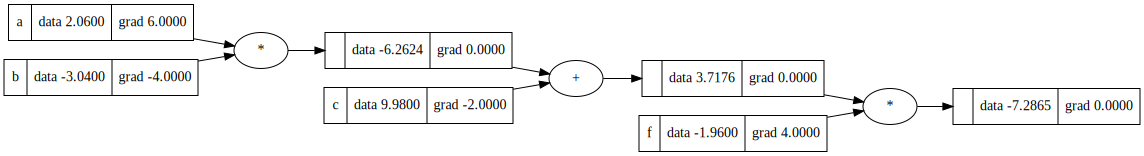

In [46]:
draw_dot(L)

In [28]:
def manual_backprop():
  a = Value(2.0,label = 'a')
  b = Value(-3.0,label = 'b')
  c = Value(10.0,label = 'c')
  e = a*b
  e.label = 'e'
  d = e+c;d.label = 'd';
  f = Value(-2.0,label = 'f')
  L = d*f;

  h = 0.00001;
  a = Value(2.0,label = 'a')
  b = Value(-3.0,label = 'b')
  c = Value(10.0+h,label = 'c')
  e = a*b
  e.label = 'e'
  d = e+c;d.label = 'd';
  f = Value(-2.0,label = 'f')
  L2 = d*f;
  print((L2.data -L.data)/h)
manual_backprop()

-1.9999999999242843


In [39]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data


$\partial L/\partial c = f$

In [40]:
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

In [42]:
# example of reducing the cost function L

a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad
e = a*b
d = e+c
L = d*f
print(L.data)

-7.286496


In [52]:
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.3,label='b')
x1w1 = x1*w1;x1w1.label = 'x1w1'
x2w2 = x2*w2;x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b;n.label = 'n'
o = n.tanh();o.label = 'o'

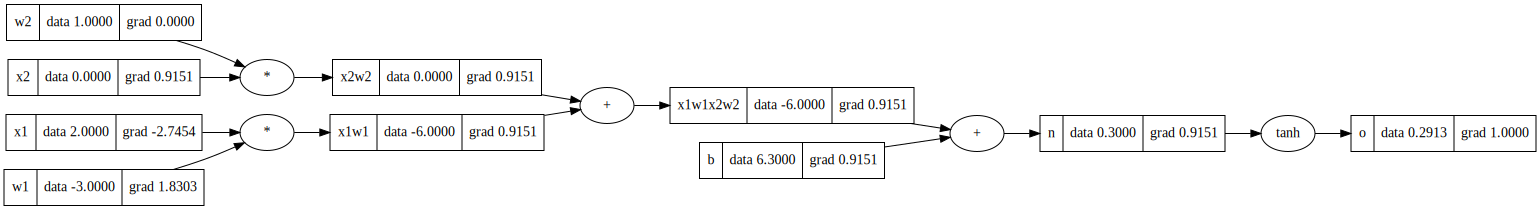

In [58]:
draw_dot(o)

In [55]:
o.grad = 1.0
n.grad = 1.0 - o.data**2
b.grad = 1.0*n.grad
x1w1x2w2.grad = 1.0*n.grad

In [57]:
x2w2.grad = 1.0*x1w1x2w2.grad
x1w1.grad = 1.0*x1w1x2w2.grad
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

In [61]:
#goated moves now

In [112]:
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.3,label='b')
x1w1 = x1*w1;x1w1.label = 'x1w1'
x2w2 = x2*w2;x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b;n.label = 'n'
o = n.tanh();o.label = 'o'


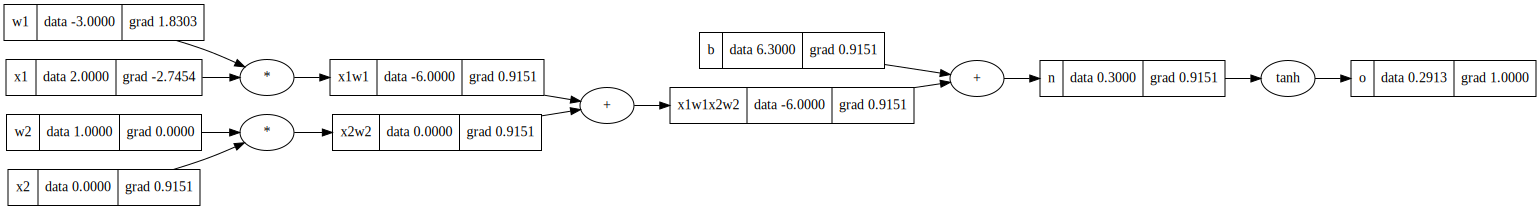

In [118]:
draw_dot(o)

In [116]:
o.grad = 1.0

In [88]:
n._backward()
x1w1x2w2._backward()
x1w1.grad = 1.0*n.grad
x2w2.grad = 1.0*n.grad
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

In [117]:
o.backward()

In [126]:
#USING PYTORCH

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.3]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b;
o = torch.tanh(n);
o.backward()


print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

-2.745410580390695
0.9151368601302318
1.8302737202604635
0.0


# dis works :happy face:


# Building own Multi Layer Perceptron (ANN)

In [270]:
import random
class Neuron:
  def __init__(self,nin) :
    self.w = []
    for x in range(nin):
      (self.w).append(Value(random.uniform(-1,1)))
    self.b = Value(random.uniform(-1, 1))
  def __call__(self,u):
    temp = self.b
    for i in range(len(self.w)):
      temp += self.w[i]*u[i]
    return temp.tanh()
  def params(self):
    return self.w + [self.b]
g = Neuron(2)
x = [1.0,2.1]
g(x)

Value [Data = 0.8717407921570889]

In [274]:
class Layer:
  def __init__(self,nin,nout):
    self.neurons = []
    for i in range(nout):
      self.neurons.append(Neuron(nin))
  def __call__(self,x):
    out = []
    for n in self.neurons:
      out.append(n(x))
    return out
  def params(self):
    out = []
    for n in self.neurons:
      ps = n.params()
      out.extend(ps)
    return out


In [275]:
class MLP:
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = []
    for i in range(len(nouts)):
      self.layers.append(Layer(sz[i],sz[i+1]))
  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    if(len(x)==1):
      return x[0]
    return x
  def params(self):
    return [p for layer in self.layers for p in layer.params()]

In [276]:
x = [2.0,3.0,-1]


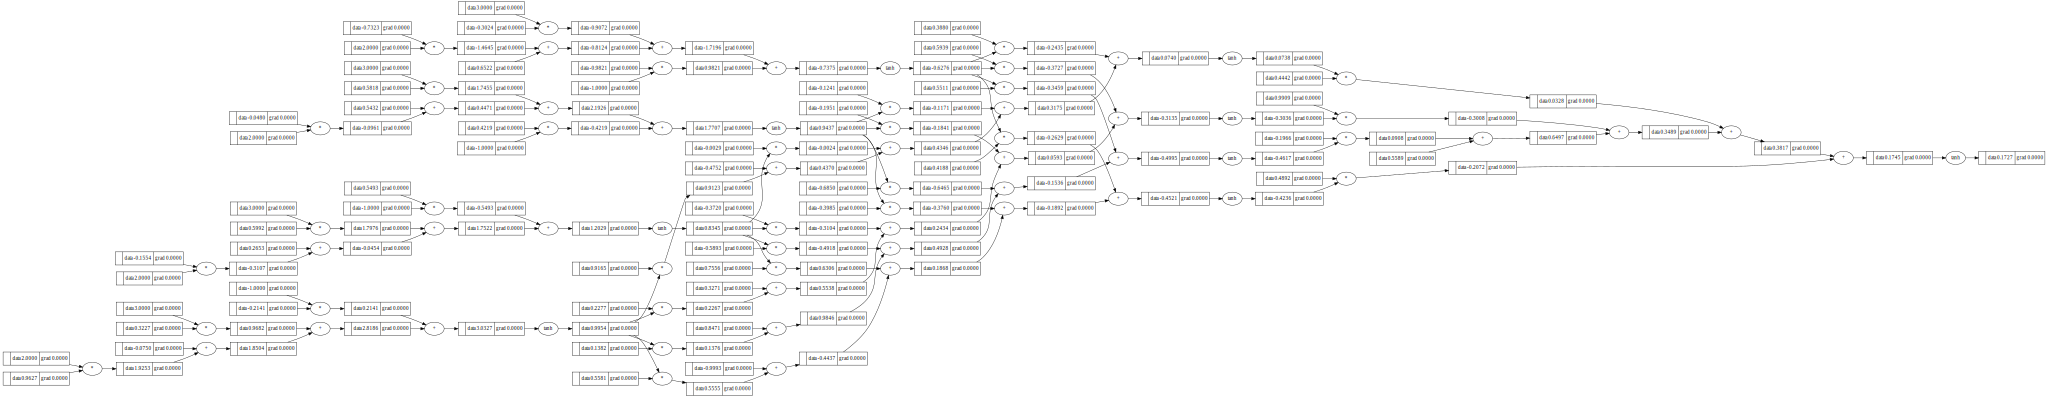

In [248]:
draw_dot(n(x))

In [314]:
xs = [[2,0,3,0,-1,0],[3,0,-1.0,0,5],[0.5,1.0,1.0],[1.0,1.0,-1.0]]
ys = [1.0,-1.0,-1.0,1.0]

In [315]:
n = MLP(3,[4,4,1]);

In [313]:
ypred = [n(x) for x in xs]
loss = Value(0.0)
for i in range(len(ys)):
  loss += (ypred[i] - ys[i])*(ypred[i] - ys[i])
loss

Value [Data = 5.669102869175503]

In [311]:
loss.backward()

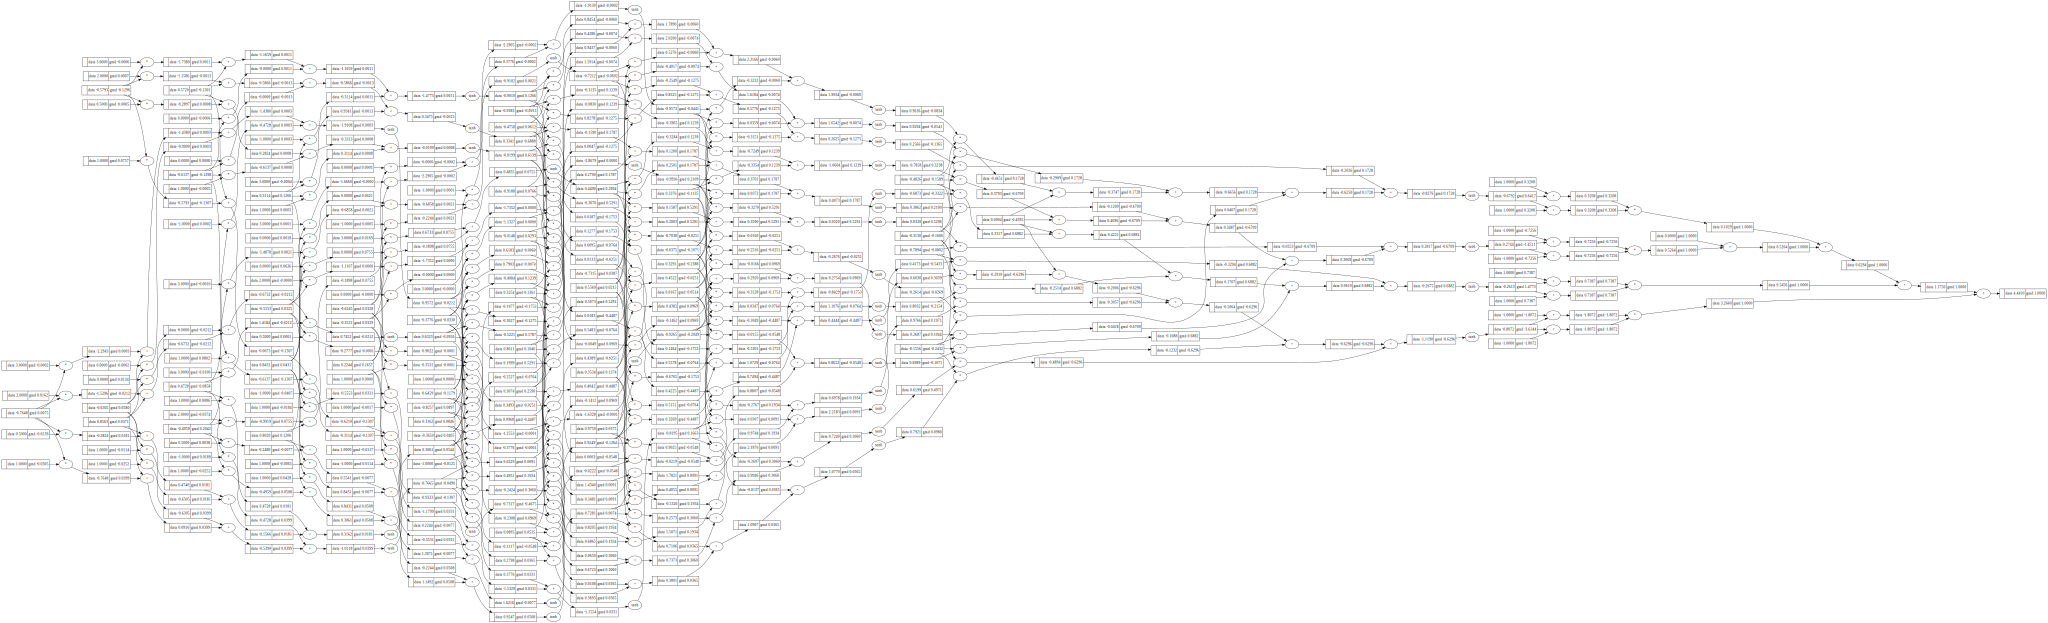

In [282]:
draw_dot(loss)

In [293]:
n.layers[0].neurons[0].w[0]

Value [Data = -0.4816602094165823]

In [285]:
len(n.params())

41

In [312]:
for p in n.params():
  p.data +=  -0.01*p.grad

In [295]:
n.layers[0].neurons[0].w[0]

Value [Data = -0.48166934590951116]

In [320]:
for k in range(40):
  ypred = [n(x) for x in xs]
  loss = Value(0.0)
  for i in range(len(ys)):
    loss += (ypred[i] - ys[i])*(ypred[i] - ys[i])
  print(f"loss: {loss.data}")
  loss.backward()
  for p in n.params():
    p.data +=  -0.01*p.grad
    p.grad = 0;

loss: 0.041144152452323335
loss: 0.051083357065779086
loss: 0.04981365086332414
loss: 0.04873603522651194
loss: 0.04772599524566512
loss: 0.04668212358605932
loss: 0.045784896265843346
loss: 0.04489820919854696
loss: 0.04401153707368096
loss: 0.04326113171576244
loss: 0.04252550633902516
loss: 0.04177916165358595
loss: 0.04106648335735435
loss: 0.040449667058519975
loss: 0.03979787896904017
loss: 0.03923404157865139
loss: 0.03864424903402743
loss: 0.038129474230845145
loss: 0.037633332930595814
loss: 0.03710150482704439
loss: 0.03660363061290433
loss: 0.03616099631886056
loss: 0.03568413796306709
loss: 0.03525652214839715
loss: 0.0348108884843872
loss: 0.03438657802517798
loss: 0.033999910239352574
loss: 0.03361770000695941
loss: 0.03325788891836678
loss: 0.03292014020840071
loss: 0.03257413872165222
loss: 0.03224762748532042
loss: 0.031904417397372604
loss: 0.03157944881362271
loss: 0.03127772931116062
loss: 0.030982857986170127
loss: 0.030672077352874003
loss: 0.03035788374553159
los

# WORKS

In [321]:
ypred

[Value [Data = 0.8912463042354366],
 Value [Data = -0.87486836237415],
 Value [Data = -0.9520624382487184],
 Value [Data = 0.9996740687548417]]